# Load Doc2Vec model

In [0]:
from gensim.models.doc2vec import Doc2Vec
import pandas as pd

model = Doc2Vec.load('doc2vec_model_task_statements/doc2vec_model_task_statements')

# Load corpus

In [0]:
from gensim.models.doc2vec import TaggedLineDocument
corpus = TaggedLineDocument("doc2vec_data/corpus_task_statements.cor")

In [0]:
for idx, i in enumerate(corpus):
    print(i.tags)
    break

[0]


In [0]:
len(model.docvecs)

457277

# Assessing doc2vec model

In [0]:
def find_corpus_docs_similar_docs():
    for doc in corpus:
        doc_id = doc.tags[0]
        inferred_vector = model.infer_vector(doc.words)
        # get only top 10
        sims = model.docvecs.most_similar([inferred_vector], topn=10)
        similar_document_ids = [doc_id for doc_id, _ in sims]
        if doc_id in similar_document_ids:
            yield doc_id, similar_document_ids.index(doc_id), similar_document_ids
        else:
            yield doc_id, 999999999999, similar_document_ids # mark some dead value

In [0]:
similar_docs_gen = find_corpus_docs_similar_docs()

In [0]:
similarities = [None] * len(model.docvecs)
for similarity in similar_docs_gen:
    if similarity[0] % 10000 == 0: 
      print("Current doc ID %d" % similarity[0])
    similarities[similarity[0]] = similarity

In [0]:
df = pd.DataFrame(similarities, columns=['doc_id','most_similar_index','top10_similarity_ranking'])

In [0]:
df.head(10)

NameError: name 'df' is not defined

## Saving findings

In [0]:
df.to_json('findings/doc2vec_task_statements_evaluation.json.gz', orient='records', lines=True, compression='gzip')

# Load evaluation

In [0]:
ev_df = pd.read_json('findings/doc2vec_task_statements_evaluation.json.gz', orient='records', lines=True, compression='gzip')

In [0]:
import collections
ranking_counter = collections.Counter(ev_df['most_similar_index'])
ranking_counter

num = ranking_counter[0]
denom = 0
for i in range(0, 10):
    denom += ranking_counter[i] 
    
print("%f%% of the documents are ranked first" % ((num / denom) * 100)) 

93.952991% of the documents are ranked first


In [0]:
l_corpus = list(corpus)

In [0]:
# sample 10 randomly
sampled = ev_df.sample(n=10, random_state=56)

comparing_docs = sampled['top10_similarity_ranking'].transform(lambda x: list(map(lambda y: l_corpus[y], x)))

In [0]:
for doc_id, similar_docs in comparing_docs.iteritems():
  print("================================")
  print("For document #%d" % doc_id)
  for idx, doc in enumerate(similar_docs[:3]):
    print("most similar #%d" % (idx + 1), doc)
  print("================================")

For document #225724
most similar #1 TaggedDocument(['worked', 'as', 'a', 'human', 'resources', 'assistant', 'throughout', '-391-', '-391-', '-391-', '-391-', '.', 'primary', 'responsibilities', 'included', ':', 'supporting', 'the', 'role', 'of', 'the', 'human', 'resources', 'director', ',', 'assisting', 'with', 'payroll', 'management', ',', 'assisting', 'with', 'hiring', 'and', 'on', '-', 'boarding', 'procedures', ',', 'and', 'general', 'administrative', 'support', 'activities', '.'], [225724])
most similar #2 TaggedDocument(['fed', ',', 'helped', 'and', 'socialized', 'with', 'elderly', 'throughout', '-391-', '-391-'], [30195])
most similar #3 TaggedDocument(['made', 'door', '-', 'to', '-', 'door', 'sales', 'throughout', '-391-', '-391-', '.', 'kept', 'a', 'good', 'work', 'ethic', 'and', 'attitude', 'throughout', '-391-', '-391-', '-391-', '-391-', '.', 'worked', 'efficiently', 'without', 'supervision', '.'], [295499])
For document #300776
most similar #1 TaggedDocument(['maintain', '

In [0]:
#with open('onet/onet_occupation_data.csv') as f:
with open('onet/tokenized_onet_occupation_task_statements.json') as f:
  num_occupation_data = len(f.readlines())
onet_occupation_similarity = [None] * len(model.docvecs) # make it simple, wasting space but okay

def compute_top5_onet_occupation_similarity():
  for doc in corpus:
    doc_id = doc.tags[0]
    if doc_id > num_occupation_data - 1:
      similarity = model.docvecs.most_similar(positive=[model.infer_vector(doc.words)], clip_start=0, clip_end=num_occupation_data - 1, topn=5)
      for similar_doc_id, similarity_val in similarity:
        yield doc_id, similar_doc_id, similarity_val

In [0]:
onet_similarity_gen = compute_top5_onet_occupation_similarity()

In [0]:
onet_similarity_l = list(onet_similarity_gen)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
df = pd.DataFrame(onet_similarity_l, columns=['doc_id', 'similar_doc_id', 'similarity'])

In [19]:
df.head(20)

,doc_id,similar_doc_id,similarity
0,974,548,0.249190
1,974,385,0.229474
2,974,541,0.205969
3,974,823,0.204701
4,974,330,0.199380
5,975,658,0.231049
6,975,547,0.193516
7,975,544,0.188837
8,975,548,0.186986
9,975,407,0.184939


## Save similarities

In [0]:
df.to_json('findings/resume_job_title_task_statements_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')
#df.to_json('findings/resume_job_title_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')

# EDA on Job Title Similarity

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load similarities

In [2]:
similarity_df = pd.read_json('findings/resume_job_title_task_statements_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')
#similarity_df = pd.read_json('findings/resume_job_title_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')

## Statistics of similarity

In [3]:
maximum = similarity_df['similarity'].max()
minimum = similarity_df['similarity'].min()
quantile_low = similarity_df['similarity'].quantile(0.25)
median = similarity_df['similarity'].median()
quantile_high = similarity_df['similarity'].quantile(0.75)
average = similarity_df['similarity'].mean()

print('Maximum similarity %f' % maximum)
print('Minimum similarity %f' % minimum)
print('25th quantile similarity %f' % quantile_low)
print('Median similarity %f' %  median)
print('75th Quantile similarity %f' % quantile_high)
print('Average similarity %f' % average)

Maximum similarity 0.898468
Minimum similarity 0.094192
25th quantile similarity 0.202070
Median similarity 0.225266
75th Quantile similarity 0.252134
Average similarity 0.229593


## Boxplot and histogram on similarity

Text(0.332229,0.97,'0.327229')

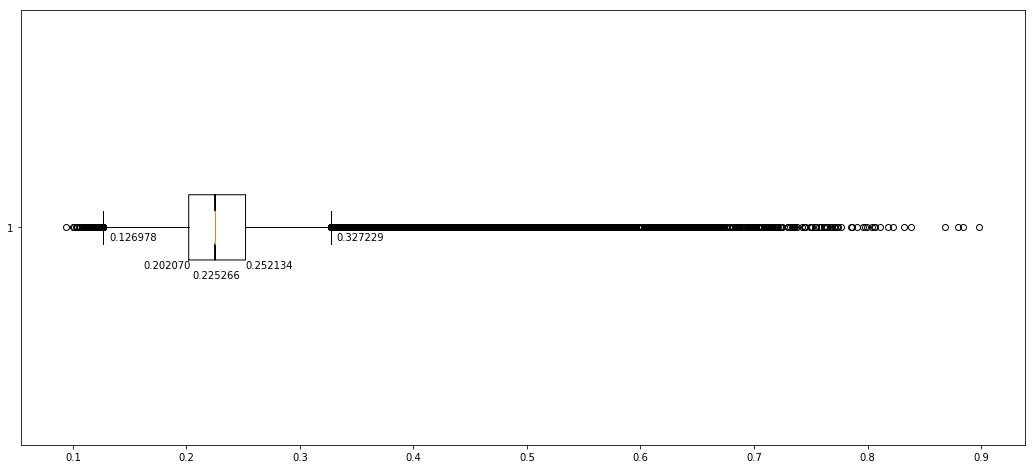

In [45]:
fig, ax = plt.subplots()

fig.set_size_inches(18, 8)
box_info = ax.boxplot(similarity_df['similarity'], notch=True, vert=False)

x, y = box_info['medians'][0].get_xydata()[0]
ax.annotate('%f' % median, (x - 0.02,y - 0.08))
x, y = box_info['boxes'][0].get_xydata()[0]
ax.annotate('%f' % quantile_low, (x - 0.04, y - 0.02))
x, y = box_info['boxes'][0].get_xydata()[6]
ax.annotate('%f' % quantile_high, (x, y - 0.02))

x, y = box_info['whiskers'][0].get_xydata()[1]
ax.annotate('%f' % box_info['whiskers'][0].get_xdata()[1], (x + 0.005, y - 0.03))

x, y = box_info['whiskers'][1].get_xydata()[1]
ax.annotate('%f' % box_info['whiskers'][1].get_xdata()[1], (x + 0.005, y - 0.03))

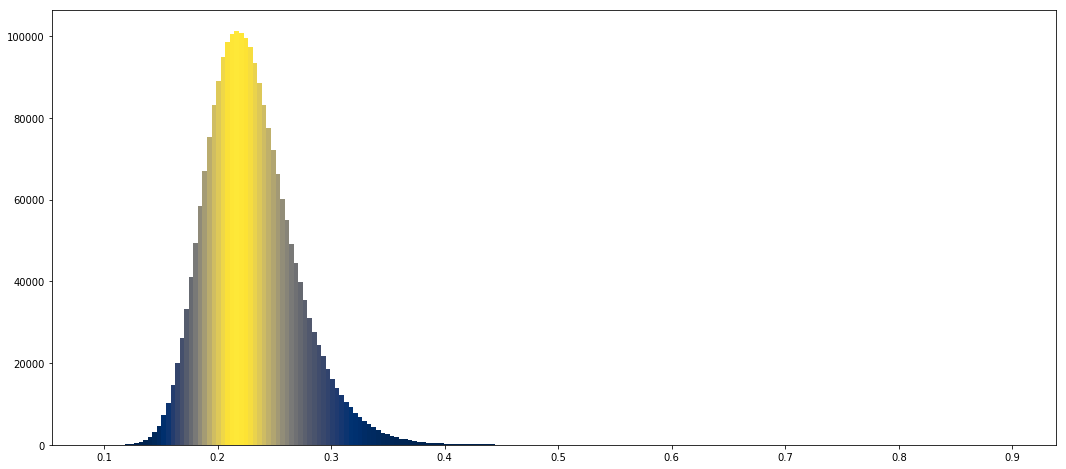

In [47]:
fig, ax = plt.subplots()

fig.set_size_inches(18, 8)
n, bins, patches = ax.hist(similarity_df['similarity'], bins=200)

# To normalize your values
cm = plt.cm.get_cmap('cividis')
col = (n-n.min())/(n.max()-n.min())
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

## Distribution of top 5 similar ONET job descriptions

In [10]:
similar_docs_sorted = similarity_df.sort_values(['similarity'], ascending=False).groupby('doc_id')

In [11]:
most_similar = []
for i in range(5):
    most_similar.append(similar_docs_sorted.nth(i))

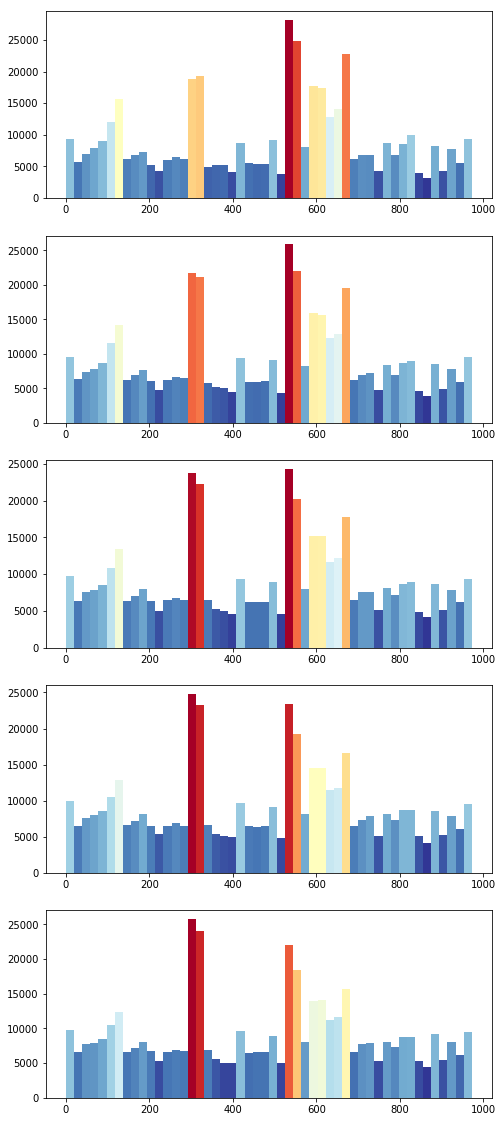

In [12]:
fig, axes = plt.subplots(5, 1)

fig.set_size_inches(8, 20)
cm = plt.cm.get_cmap('RdYlBu_r')
onet_docs_similar_bins = []
onet_docs_similar_count_values = []
for i in range(5):
    n, bins, patches = axes[i].hist(most_similar[i]['similar_doc_id'], bins=50)
    onet_docs_similar_bins.append(bins)
    onet_docs_similar_count_values.append(n)
    col = (n-n.min())/(n.max()-n.min())
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

In [11]:
# inspecting the bins from the above most similar histogram and taking the desired values
# it should contain bin values over onet job description IDs on the corpus
onet_docs_similar_bins

[array([  0.  ,  19.44,  38.88,  58.32,  77.76,  97.2 , 116.64, 136.08,
        155.52, 174.96, 194.4 , 213.84, 233.28, 252.72, 272.16, 291.6 ,
        311.04, 330.48, 349.92, 369.36, 388.8 , 408.24, 427.68, 447.12,
        466.56, 486.  , 505.44, 524.88, 544.32, 563.76, 583.2 , 602.64,
        622.08, 641.52, 660.96, 680.4 , 699.84, 719.28, 738.72, 758.16,
        777.6 , 797.04, 816.48, 835.92, 855.36, 874.8 , 894.24, 913.68,
        933.12, 952.56, 972.  ]),
 array([  0.  ,  19.44,  38.88,  58.32,  77.76,  97.2 , 116.64, 136.08,
        155.52, 174.96, 194.4 , 213.84, 233.28, 252.72, 272.16, 291.6 ,
        311.04, 330.48, 349.92, 369.36, 388.8 , 408.24, 427.68, 447.12,
        466.56, 486.  , 505.44, 524.88, 544.32, 563.76, 583.2 , 602.64,
        622.08, 641.52, 660.96, 680.4 , 699.84, 719.28, 738.72, 758.16,
        777.6 , 797.04, 816.48, 835.92, 855.36, 874.8 , 894.24, 913.68,
        933.12, 952.56, 972.  ]),
 array([  0.  ,  19.44,  38.88,  58.32,  77.76,  97.2 , 116.64, 136.

In [12]:
# inspecting the count values from the above most similar histogram and taking the desired values
onet_docs_similar_count_values

[array([ 9320.,  5754.,  7018.,  7897.,  9001., 11966., 15647.,  6121.,
         6757.,  7326.,  5163.,  4260.,  6009.,  6547.,  6161., 18894.,
        19290.,  4978.,  5161.,  5265.,  4130.,  8694.,  5527.,  5308.,
         5418.,  9248.,  3738., 28240., 24827.,  8077., 17699., 17379.,
        12815., 14141., 22825.,  6130.,  6874.,  6749.,  4251.,  8641.,
         6778.,  8522.,  9970.,  3905.,  3166.,  8244.,  4338.,  7812.,
         5517.,  9412.]),
 array([ 9588.,  6343.,  7422.,  7842.,  8743., 11547., 14144.,  6218.,
         6885.,  7718.,  6062.,  4791.,  6269.,  6729.,  6524., 21728.,
        21136.,  5836.,  5246.,  5058.,  4456.,  9350.,  5973.,  5889.,
         6017.,  9061.,  4341., 25864., 21952.,  8193., 15880., 15638.,
        12312., 12953., 19531.,  6211.,  6970.,  7308.,  4727.,  8432.,
         6988.,  8688.,  9013.,  4591.,  3943.,  8555.,  4977.,  7772.,
         5950.,  9546.]),
 array([ 9705.,  6399.,  7577.,  7855.,  8501., 10922., 13414.,  6422.,
         700

## Finer look into the number of ONET jobs matched similar

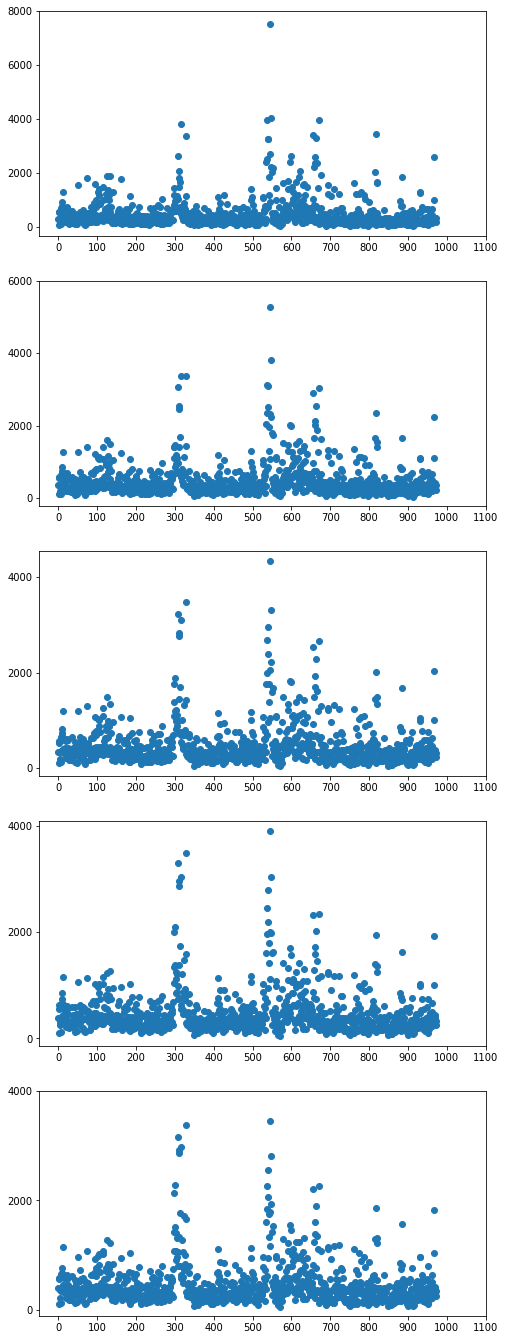

In [13]:
# course look
fig, axes = plt.subplots(5, 1)
fig.set_size_inches(8, 24)
for i in range(5):
    count_of_similar_onet_jobs = most_similar[i]['similar_doc_id'].value_counts()
    axes[i].scatter(count_of_similar_onet_jobs.index, count_of_similar_onet_jobs)
    axes[i].set_xticks(range(0, 1200, 100))
    axes[i].set_yticks(range(0, count_of_similar_onet_jobs.max() + 1000, 2000))

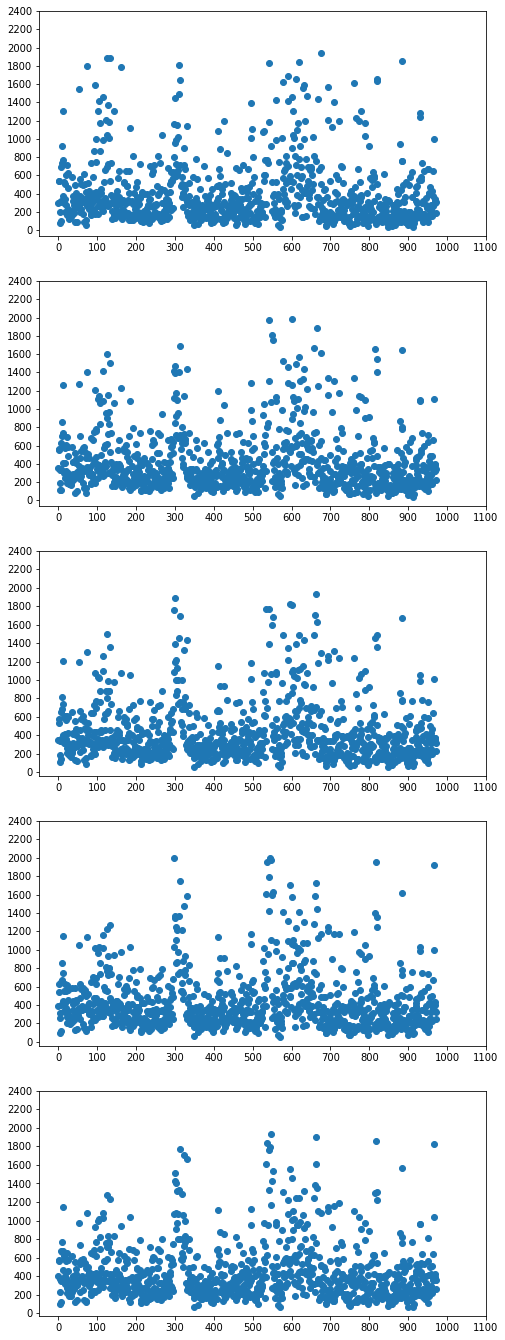

In [14]:
# take only those whose count is less than 2000, where it seems the concentration is
limit = 2000

fig, axes = plt.subplots(5, 1)
fig.set_size_inches(8, 24)
for i in range(5):
    count_of_similar_onet_jobs = most_similar[i]['similar_doc_id'].value_counts()
    filtered = count_of_similar_onet_jobs[count_of_similar_onet_jobs <= limit]
    axes[i].scatter(filtered.index, filtered)
    axes[i].set_xticks(range(0, 1200, 100))
    axes[i].set_yticks(range(0, 2500, 200))

## Checking the actual similar job details and descriptions

In [4]:
# get corpus mapping
from pyspark.sql import SparkSession
from pyspark.sql import types
from lib.schemas import SchemaDoc2VecEvaluation

spark = SparkSession.builder.appName('evaluating doc2vec').getOrCreate()
spark.sparkContext.setLogLevel('WARN')

corpus_id_schema = types.StructType([
    types.StructField('id', types.IntegerType()),
    types.StructField('source_id', types.LongType())
])
#corpus_id_mapping = spark.read.csv('doc2vec_data/corpus_id_mapping.csv', schema=corpus_id_schema)
corpus_id_mapping = spark.read.csv('doc2vec_data/corpus_task_statements_id_mapping.csv', schema=corpus_id_schema)
corpus_id_mapping = corpus_id_mapping.toPandas()

#job_details = spark.read.json('er_resume_preprocessed', schema=SchemaDoc2VecEvaluation.get_resume_er_schema())
job_details = spark.read.json('tokenized_job_details_for_doc2vec', schema=SchemaDoc2VecEvaluation.get_tokenized_task_statements_schema())
job_details = job_details.toPandas()
spark.stop()

## Finding documents from max, avg, min statistics etc.

In [6]:
sorted_similarity = similarity_df['similarity'].sort_values(ascending=False)
maximum_idx = similarity_df['similarity'].idxmax()
minimum_idx = similarity_df['similarity'].idxmin()
quantile_low_idx = sorted_similarity[sorted_similarity <= quantile_low].idxmax()
median_idx = sorted_similarity[sorted_similarity <= median].idxmax()
quantile_high_idx = sorted_similarity[sorted_similarity <= quantile_high].idxmax()

print('Maximum similarity index is %d with document ID %d and similarity score %f' % (maximum_idx, similarity_df.loc[maximum_idx, 'doc_id'], similarity_df.loc[maximum_idx, 'similarity']))
job_document_id = corpus_id_mapping.loc[similarity_df.loc[maximum_idx, 'doc_id']].source_id
job_details[job_details.id == job_document_id]

Maximum similarity index is 1471235 with document ID 295221 and similarity score 0.898468


,id,resume_id,job_title,tokenized_details
174939,8589951817,211bbd3e1a5023cb,Loans Officer,"[ , approve, loans, within, specified, limits,..."


In [54]:
corpus_id_mapping

,id,source_id
0,0,11-1011.00
1,1,11-1011.03
2,2,11-1021.00
3,3,11-1031.00
4,4,11-2011.00
5,5,11-2011.01
6,6,11-2021.00
7,7,11-2022.00
8,8,11-2031.00
9,9,11-3011.00


In [13]:
# this is just code for bins of interest (basically document groupings in the above histogram graphs
# that we are interested in to inspect further)
"""
bins_of_interest = [
    {
        "name": "most_common_most_similar",
        "bin": -1,
        "print_fmt": "The maximum value for the first hist diagram is at the %d-th index"
    },
    {
        "name": "most_common_second_most_similar",
        "bin": -1,
        "print_fmt": "The maximum value for the second hist diagram is at the %d-th index"
    },
    {
        "name": "second_most_common_third_most_similar",
        "bin": -2,
        "print_fmt": "The second highest value for the third hist diagram is at the %d-th index"
    },
    {
        "name": "second_most_common_fourth_most_similar",
        "bin": -2,
        "print_fmt": "The second highest value for the fourth hist diagram is at the %d-th index"
    },
    {
        "name": "most_common_fifth_most_similar",
        "bin": -1,
        "print_fmt": "The maximum value for the fifth hist diagram is at the %d-th index"
    },
]
"""

bins_of_interest = [
    {
        "name": "task_statements_most_common_most_similar",
        "bin": -1,
        "print_fmt": "The maximum value for the first hist diagram is at the %d-th index"
    },
    {
        "name": "task_statements_second_most_common_second_most_similar",
        "bin": -2,
        "print_fmt": "The second highest value for the second hist diagram is at the %d-th index"
    },
    {
        "name": "task_statements_second_most_common_third_most_similar",
        "bin": -2,
        "print_fmt": "The second highest value for the third hist diagram is at the %d-th index"
    },
    {
        "name": "task_statements_fourth_most_common_fourth_most_similar",
        "bin": -4,
        "print_fmt": "The fourth highest value for the fourth hist diagram is at the %d-th index"
    },
    {
        "name": "task_statements_second_common_fifth_most_similar",
        "bin": -5,
        "print_fmt": "The fifth highest for the fifth hist diagram is at the %d-th index"
    },
]

In [14]:
import numpy as np

# take different kinds of maximum to spread out the document checks

doc_range_of_interest = []
for idx, interest in enumerate(bins_of_interest):
    argmax = onet_docs_similar_count_values[idx].argpartition(interest['bin'])[interest['bin']]
    print(interest['print_fmt'] % argmax)
    doc_range_of_interest.append((interest['name'], argmax - 1, argmax))

The maximum value for the first hist diagram is at the 27-th index
The second highest value for the second hist diagram is at the 28-th index
The second highest value for the third hist diagram is at the 15-th index
The fourth highest value for the fourth hist diagram is at the 28-th index
The fifth highest for the fifth hist diagram is at the 34-th index


In [19]:
def merge_onet_data_with_corpus_mapping(onet_data_path, onet_key, reader_func=pd.read_csv, **kwargs):
    onet_data = reader_func(onet_data_path, **kwargs)
    onet_data = onet_data.merge(corpus_id_mapping, how='inner', left_on=onet_key, right_on='source_id')
    return onet_data

In [20]:
#onet_data = merge_onet_data_with_corpus_mapping('onet/onet_occupation_data.csv', 'O*NET-SOC Code')
merged_onet_data = merge_onet_data_with_corpus_mapping('onet/tokenized_onet_occupation_task_statements.json', 'onet_job_id', reader_func=pd.read_json, orient='records', lines=True)

ValueError: You are trying to merge on object and float64 columns. If you wish to proceed you should use pd.concat

In [24]:
merged_onet_data

,onet_job_id,onet_job_title,task,id,source_id
0,11-1011.00,Chief Executives,"[direct, or, coordinate, an, organization, 's,...",0,11-1011.00
1,11-1011.03,Chief Sustainability Officers,"[develop, or, execute, strategies, to, address...",1,11-1011.03
2,11-1021.00,General and Operations Managers,"[review, financial, statements, ,, sales, or, ...",2,11-1021.00
3,11-1031.00,Legislators,"[analyze, and, understand, the, local, and, na...",3,11-1031.00
4,11-2011.00,Advertising and Promotions Managers,"[plan, and, prepare, advertising, and, promoti...",4,11-2011.00
5,11-2011.01,Green Marketers,"[analyze, green, product, marketing, or, sales...",5,11-2011.01
6,11-2021.00,Marketing Managers,"[identify, ,, develop, ,, or, evaluate, market...",6,11-2021.00
7,11-2022.00,Sales Managers,"[direct, and, coordinate, activities, involvin...",7,11-2022.00
8,11-2031.00,Public Relations and Fundraising Managers,"[identify, main, client, groups, and, audience...",8,11-2031.00
9,11-3011.00,Administrative Services Managers,"[monitor, the, facility, to, ensure, that, it,...",9,11-3011.00


In [17]:
def merge_job_details_with_corpus_mapping(job_details, job_key):
    # merging corpus ID mapping with job_details
    job_details = job_details.rename({job_key:'job_id'}, axis='columns')
    job_details = job_details.astype({'job_id': str})
    job_details = job_details.merge(corpus_id_mapping, how='inner', left_on='job_id', right_on = 'source_id')
    return job_details

In [14]:
merged_job_details = merge_job_details_with_corpus_mapping(job_details, 'id')

In [15]:
merged_job_details

,job_id,resume_id,job_title,tokenized_details,id,source_id
0,0,fb0bf1895d850b1c,Systems Analyst,"[location, :, keysight(client, ), tools, :, .n...",237888,0
1,1,fb0bf1895d850b1c,Senior Software Engineer,"[location, :, egonzehnder(client, ), tools, :,...",237889,1
2,2,fb0bf1895d850b1c,Lead Engineer,"[duration, :, -391-, -391-, -391-, -391-, -391...",237890,2
3,3,fb0bf1895d850b1c,Lead Engineer,"[location, :, hcl, technologies, ., tools, :, ...",237891,3
4,4,fb0bf1895d850b1c,Senior Software Engineer,"[location, :, analecinfotech, ,, -384-, ., too...",237892,4
5,5,fb0bf1895d850b1c,Software Engineer,"[location, :, xchanging, ,, -384-, ., tools, :...",237893,5
6,6,fb0bf1895d850b1c,Software Engineer,"[location, :, xchanging, ,, -384-, ., tools, :...",237894,6
7,7,026837beec68f4b7,Firmware Engineer,"[design, and, implement, firmware, for, iot, p...",237895,7
8,8,026837beec68f4b7,Embedded Software Engineer,"[responsibilities, develop, software, for, oil...",237896,8
9,9,026837beec68f4b7,Software Engineer,"[primary, responsibilities, include, porting, ...",237897,9


In [15]:
from math import ceil, floor

def get_similar_documents_of_interest(docs_interested, desired_keys):
    # getting some samples
    similar_document_checks = {}
    for idx, interest in enumerate(doc_range_of_interest):
        interest_name = interest[0]
        low_idx = interest[1]
        high_idx = interest[2]

        low_range = ceil(onet_docs_similar_bins[idx][low_idx])
        high_range = floor(onet_docs_similar_bins[idx][high_idx])
        where = (most_similar[idx].similar_doc_id >= low_range) & (most_similar[idx].similar_doc_id <= high_range)
        df_sampled_similarities = most_similar[idx].loc[where, ['similar_doc_id', 'similarity']].sample(n=100, random_state=42)
        df_sampled_similarities = df_sampled_similarities.reset_index()
        df_sampled_similarities = df_sampled_similarities.astype(str)
        df_sampled_similarities = df_sampled_similarities.merge(merged_onet_data, how='inner', left_on='similar_doc_id', right_on='id')
        # avoid colum conflict
        df_sampled_similarities = df_sampled_similarities.drop('id', axis='columns')

        # merge and get relevant info
        merged_similar_jobs_with_info = merged_job_details.merge(df_sampled_similarities, how='inner', left_on='id', right_on='doc_id')
        merged_similar_jobs_with_info = merged_similar_jobs_with_info[desired_keys]

        # store
        similar_document_checks[interest_name] = merged_similar_jobs_with_info
    return similar_document_checks

In [16]:
# this is for data from ER stage
# similar_documents_of_interest = get_similar_documents_of_interest(doc_range_of_interest, ['job_title', 'job_details', 'Title', 'Description'])

# this is for data as task statements
similar_documents_of_interest = get_similar_documents_of_interest(doc_range_of_interest, ['onet_job_id', 'job_title', 'tokenized_details', 'onet_job_title', 'task'])

NameError: name 'merged_onet_data' is not defined

### Save sampled results

In [30]:
import os

# again for data from ER stage
#filename_fmt = 'er_doc2vec_docs_results_%s.json'

# this is for data as task statements
filename_fmt = 'task_statements_doc2vec_docs_results_%s.json'

for interest_name, similar_documents in similar_documents_of_interest.items():
    similar_documents.to_json(os.path.join('findings', filename_fmt % interest_name), orient='records', lines=True)